Title: Know Thy Enemy-- AI Diffusers   
Date: 2023-03-17   
Category: Tech   
Tags: Simulations   
Slug: diffusing-diffusers   
Summary: If AI is gonna take over the world, lets at least fuckin' know how it works on a deep level

AI Sucks.

There's really no two ways around it. It was, perhaps, always destined to suck: the word robot (often going hand in hand with AI, artificial minds for artificial bodies) comes from a Czech word _robota_ meaning forced labor. This has always been the story of replacing a living, wonderful thing with something we could boss around, consequence free.

[deeper dive into the source play here, maybe?]

Is it any wonder that I-Got-An-Ivy-League-Business-Degree-And-Then-Did-A-Stint-At-McKennly CEOs have a hard-on for this shit? In a very real sense, every single AI practitioner (myself included!) has been building the torment nexus [link to tweet] since long before I was born. We've inherited a field with some deeply anti-humanistic biases and practices.

[other things to use to set up the investigation: see if Clark really thought a lot about the whole "any technology is magic" quote, and if not, start citing Penn and Teller like an asshole]

But, I also believe there's still time. We can turn this ship around, if we choose to. I believe that this means we need to deeply understand the current tools-- what they do, what they don't do, how they work, the chain of decisions that got us here-- in order to have a grounded enough understanding to build better ones.

So

Let's dive in. What the ever-living-fuck is a diffuser, anyway?

### What the Ever Living Fuck is a Diffuser

Well, HuggingFace says that
> 🤗 Diffusers is the go-to library for state-of-the-art pretrained diffusion models for generating images, audio, and even 3D structures of molecules.

The emoji is part of that sentence, by the way. That's the official way to say HuggingFace. Let's take a pause to really revel in that cringe. Ah.

Fine, diffusers is a library of pretrained diffusion models. These models generate images, audio and 3D structures. Swanky. So... what are they? For this post, I'll be mostly working from [this survey paper](https://arxiv.org/abs/2306.04542). I want to acknowledge that this paper is some dark academia[^1] bullshit-- as far as I can tell, it only exists in arXiv preprint form, and has never been peer reviewed. I used to get really annoyed by this shit, but at least it's not someone trying to sneak humanities discourse as Atlantic articles [insert Ian Bogost barb here]. Don't let the formatting fool you.

Any machine learned model can be split into two processes:
* **training** This is how the model "learns" stuff-- training is the process that is run on a Whole Fuckton of data and what you get out is a "learned" function
* **inference** This is using that "learned" function to do something, like generate a picture or a 3D model

This split begs several questions: 
1. How does training happen?
2. What does the model "learn"?
3. How does the model use this "learned" information to do something useful?

Oh boy that looks like an outline!
[^1]: oh fuck me, this is an alt-right thing now, isn't it? _goddamnit_

### But, let's back up for a second -- what are we trying to do with our diffuser?

I'm going to focus on image generation here-- it helps keep the example grounded, but the processes and systems I'm gonna talk about can work for a surprising number of things.

To quote a great sage of our time, the EDM Artist Dabin:
> Made something out of nothing \
> found something deep inside \
> I'll always keep on running \
> that's what it means to be alive

Computers are not alive, and can't create something out of nothing. In classical procedural content generation / random number theory, we call that initial thing the computer is going to work from a "seed". For random numbers, it's often based on your computer's clock ([but can get as wild as the chaotic fluctuations in a laser](https://help.roll20.net/hc/en-us/articles/360037256594-Quantum-Roll)). For making images with stable diffusion, it's static. I mean that literally: we used to have TV that came over the air, and if you set your dial to look for a frequency in which there was no nearby station, you got a fuzz of black and white that was the result of whatever random radio waves you could grab. They might not have even been man made-- at least some of the radio signal your TV would pick up would have been cosmic background radiation from the big bang.

The world is so much cooler when you're even the tiniest bit curious.

The technical term for all this randomness is "noise", and its noise that diffusion algorithms use as their seed. To generate an image with Stable Diffusion, you start with a pattern very similar to the static on a TV and something mysterious happens, and you get a picture of a person with seven fingers.

[this might be a good point to start showing insturmented versions of SD, from the C++ version]

### How does training a diffusion model happen?

What we need to learn is that "magic": the bit that can somehow take random noise and turn it into an image. Diffusers do this using two pipelines
* the forward pipeline, which adds noise to an image until it's basically full noise
* the backwards pipeline, which learns how to go from full noise back to the original image

Noise is slowly added in steps, usually a predefined number or until the whole image is saturated with noise. PICK BACK UP HERE!!

The backwards pipeline is what the model learns-- we tell it to figure out how on earth it's going to go backwards. We "train" the model to iteratively remove noise, something like the perfect reverse of adding noise. These two pipelines: the fixed "add noise" pipeline and the "learned" "remove noise" pipeline are what diffusion models are. 
[link to a reverse image of nosification happening above] 

In [4]:
# ok, yeah, I'm gonna grab some stuff from HF. I'll jam it in tmp for now to showcase this process. 
# going through training with some local data

# config class
from dataclasses import dataclass
@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "../tmp/diffusers_talk_model"  # the model name locally and on the HF Hub
    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_model_id = "not-uploading/does-not-matter"  # the name of the repository to create on the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0
    dataset_name=""
    data_dir=""

config = TrainingConfig()

In [12]:
from datasets import load_dataset
config.dataset_name = "imagefolder"
config.data_dir = "../tmp/diffusers_talk_images/"
dataset = load_dataset(config.dataset_name, data_dir=config.data_dir, split="train")

/var/folders/7w/3t_b1j3569x4kpjtvdfnv_bm0000gn/T/ipykernel_50020/1671847463.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


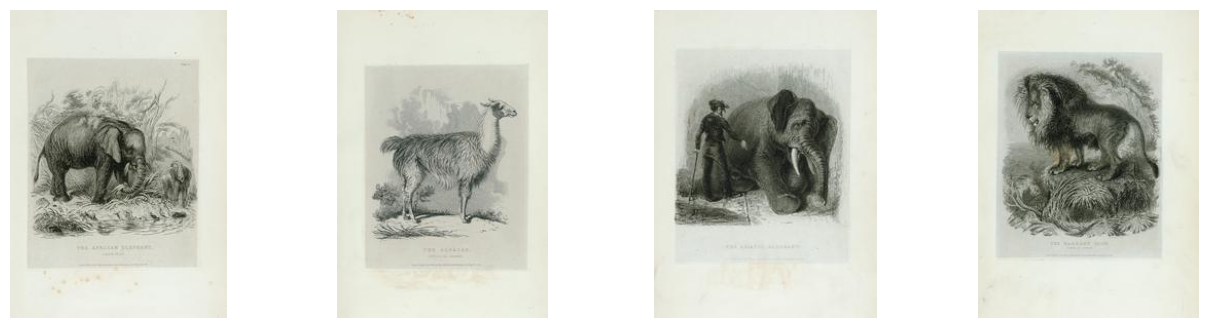

In [15]:
# lets look at some data
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [16]:
# lets normalize
from torchvision import transforms
preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]
)
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/var/folders/7w/3t_b1j3569x4kpjtvdfnv_bm0000gn/T/ipykernel_50020/3184779332.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


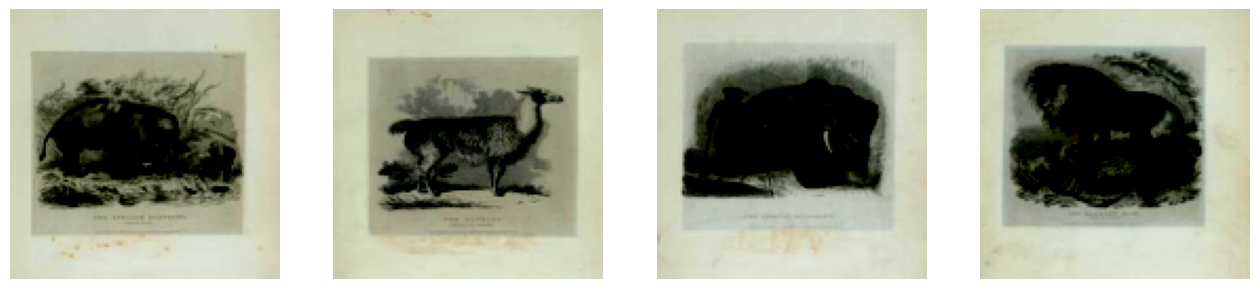

In [28]:
# did we actually do the thing?
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["images"]):
    axs[i].imshow(image.transpose(2, 0).transpose(0, 1))
    axs[i].set_axis_off()
fig.show()
# these warnings are expected, as matplotlib can't visualize the -1, 1 range that we've normalized all our data into

In [29]:
# get a data loader together
import torch
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

In [30]:
from diffusers import UNet2DModel
model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    )
)

In [31]:
# evaluate that everything lines up
sample_image = dataset[0]["images"].unsqueeze(0)
print(f"Input data shape: {sample_image.shape}")
print(f"Model will output things of shape: {model(sample_image, timestep=0).sample.shape}")

Input data shape: torch.Size([1, 3, 128, 128])
Model will output things of shape: torch.Size([1, 3, 128, 128])


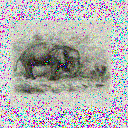

In [32]:
# OK now we gotta add some noise
from PIL import Image
from diffusers import DDPMScheduler #type: ignore
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps) #type: ignore

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

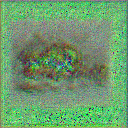

In [35]:
# and this is where the machine learning happens-- use the model to _predict_ where the noise was added
import torch.nn.functional as F
noise_pred = model(noisy_image, timesteps).sample
Image.fromarray(((noise_pred.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [36]:
# we can get traditional MSE loss from this
loss = F.mse_loss(noise_pred, noise) # this is the mean squared error, L2 error, the usual thing. It's a way to measure the distance between what you wanted and what you got
print(f"Loss between noisy sample and predicted noise: {loss}")

# that can now back propigate through network to update our weights (the "backward") part of learning 
# we then do the usual stuff with an optimizer and learning rate scheduler

Loss between noisy sample and predicted noise: 1.1479614973068237


### Ok, all of this is kinda all over the place lets go from the top

Five parts of a Diffuser:
1. adding noise --- training part
2. learning to turn noise back into picture --- training part
3. using (2) to generate new stuff
4. but pixel space is very large, lets use embeddings
5. conditioning embeddings with other stuff (VAE)

This talk is for a general audience, so I'll try to stay away from the terrifying closet space that is things like DDPMs and rule based noise schedules and the like.

### Adding Noise

The so-called forward process of a diffuser-- take an image (A) and add noise to it in steps.

[insert image here]()

These steps are fixed, as part of training the model, we always add noise in this way. Each new image we train on gets the algorithm of noise applied to it, with the same parameters. This is often referred to as a _noise schedule_, and this noise is not purely random: it does have certain math properties that are handy (it usually set up such that the noised image can be considered a bunch of random isotropic variables).

### Making an image from nothing

The so-called backwards part of this training process is what we actually care about-- getting an image back out from the noise. We train a series of steps to _denoise_ an image, such that by the end of it, we can see our original image again.

[insert image here]()

This is where a big chunk of the neural network ML magic comes in: these steps, to get the original image out from the static, are learned.